### Train & Save ClassicalPipeline

Train the `ClassicalPipeline` **training set**, evaluate on **dev** and **test**, and save the fitted pipeline.

In [2]:
import os

import random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from utils import get_image_paths_and_labels, plot_cm_subset
from ClassicalPipeline import ClassicalPipeline, ImageLoader

TRAIN_DIR = '../data/asl_alphabet_train'
DEV_DIR = '../data/asl_alphabet_dev'
TEST_DIR = '../data/synthetic_test'

seed = 42
random.seed(seed)
np.random.seed(seed)

train_paths, train_labels = get_image_paths_and_labels(TRAIN_DIR)
dev_paths, dev_labels = get_image_paths_and_labels(DEV_DIR)
test_paths, test_labels = get_image_paths_and_labels(TEST_DIR)

classes = sorted(os.listdir(TRAIN_DIR))
subset_to_plot = [clazz for clazz in classes if clazz not in ['del', 'space']]

#### PCA Reconstruction Examples

We fit a PCA on the **train** set, then randomly sample 5 images from **dev** and 5 from **test**,
project down to the PCA subspace and back, and display original vs. reconstructed.

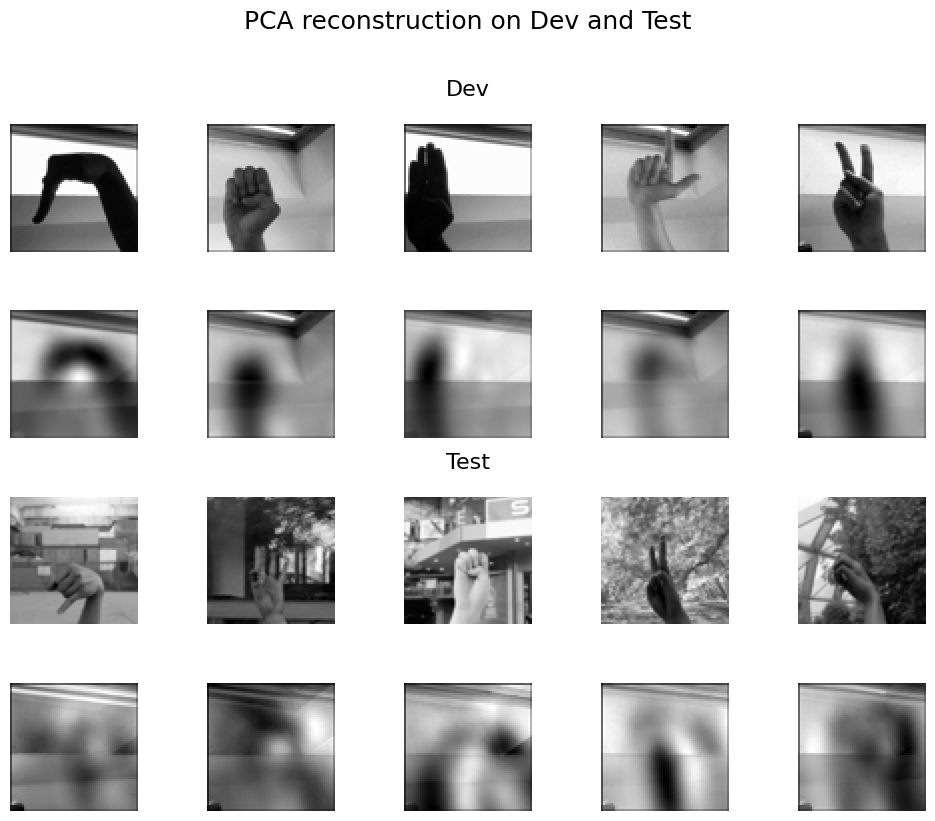

In [3]:
random.seed(seed)
np.random.seed(seed)

# 1) Fit PCA on TRAIN
X_train = ImageLoader(size=(64, 64)).fit_transform(train_paths)
pca = PCA(n_components=20, random_state=42)
pca.fit(X_train)

# 2) Sample from DEV and TEST
dev_sample = random.sample(dev_paths, 5)
test_sample = random.sample(test_paths, 5)
loader = ImageLoader(size=(64, 64))


def load_and_reconstruct(paths):
    X = loader.transform(paths)
    X_low = pca.transform(X)
    X_rec = pca.inverse_transform(X_low)
    return X, X_rec


X_dev, X_dev_rec = load_and_reconstruct(dev_sample)
X_test, X_test_rec = load_and_reconstruct(test_sample)

# 3) Plot
n_cols = len(dev_sample)
fig, axs = plt.subplots(4, n_cols, figsize=(n_cols * 2, 8), sharex=True, sharey=True)

# Turn off spacing between subplots
plt.subplots_adjust(wspace=0.05, hspace=0.05)

# DEV originals & reconstructions
for i in range(n_cols):
    # dev original
    axs[0, i].imshow(X_dev[i].reshape(64, 64), cmap='gray')
    axs[0, i].axis('off')
    # dev reconstructed
    axs[1, i].imshow(X_dev_rec[i].reshape(64, 64), cmap='gray')
    axs[1, i].axis('off')

# TEST originals & reconstructions
for i in range(n_cols):
    axs[2, i].imshow(X_test[i].reshape(64, 64), cmap='gray')
    axs[2, i].axis('off')
    axs[3, i].imshow(X_test_rec[i].reshape(64, 64), cmap='gray')
    axs[3, i].axis('off')

# Centered block titles
mid = n_cols // 2
axs[0, mid].set_title('Dev', fontsize=16, pad=20)
axs[2, mid].set_title('Test', fontsize=16, pad=20)

axs[0, 0].set_ylabel('Original', fontsize=12, rotation=90, labelpad=10)
axs[1, 0].set_ylabel('Reconstructed', fontsize=12, rotation=90, labelpad=10)
axs[2, 0].set_ylabel('Original', fontsize=12, rotation=90, labelpad=10)
axs[3, 0].set_ylabel('Reconstructed', fontsize=12, rotation=90, labelpad=10)

fig.suptitle(
    'PCA reconstruction on Dev and Test',
    fontsize=18,
    y=1.02  # push it up above the subplots
)
plt.tight_layout()
plt.show()

#### The pipeline

Display the underlying sklearn pipeline


In [3]:
pipe = ClassicalPipeline()
pipe.plot_pipeline()

Pipeline(steps=[('loader',
                 <ClassicalPipeline.ImageLoader object at 0x32492b150>),
                ('pca', PCA(n_components=20, random_state=42)),
                ('scaler', StandardScaler()),
                ('clf',
                 RandomForestClassifier(max_depth=20, max_features=0.3,
                                        n_estimators=200, n_jobs=13,
                                        random_state=42))])

#### Training

In [4]:
pipe.fit(train_paths, train_labels)
print("Trained ClassicalPipeline on train")

Trained ClassicalPipeline on train


#### Evaluate on dev

### DEV SET ###
Accuracy     : 0.9887
Macro-F1     : 0.9887


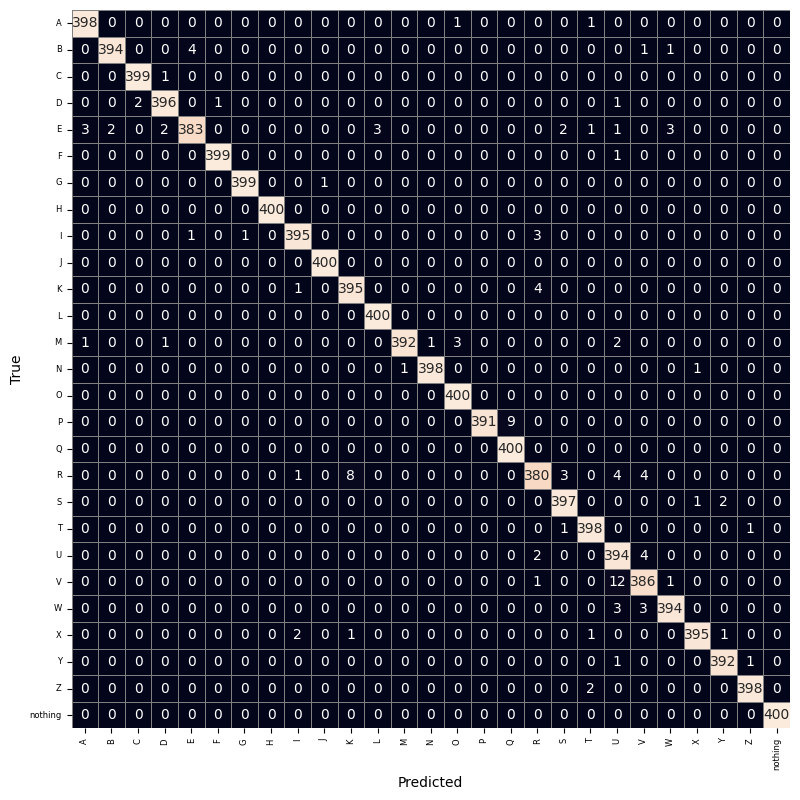

In [5]:
dev_metrics = pipe.evaluate(dev_paths, dev_labels)

print("### DEV SET ###")
print(f"Accuracy     : {dev_metrics['accuracy']:.4f}")
print(f"Macro-F1     : {dev_metrics['f1_macro']:.4f}")

plot_cm_subset(dev_metrics['cm'], classes, subset_to_plot)

#### Evaluate on test

### TEST SET ###
Accuracy     : 0.0441
Macro-F1     : 0.0249


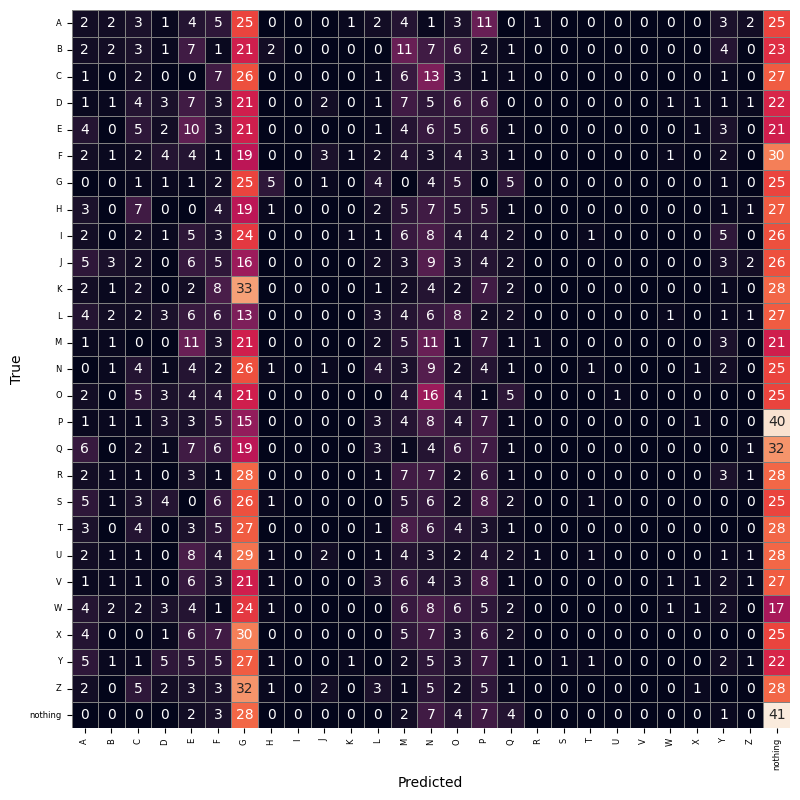

In [6]:
test_metrics = pipe.evaluate(test_paths, test_labels)

print("### TEST SET ###")
print(f"Accuracy     : {test_metrics['accuracy']:.4f}")
print(f"Macro-F1     : {test_metrics['f1_macro']:.4f}")

plot_cm_subset(test_metrics['cm'], classes, subset_to_plot)

#### Save model

In [7]:
out = Path('../models') / 'classical_pipeline.pkl'
out.parent.mkdir(exist_ok=True, parents=True)
pipe.save(str(out))
print(f"Saved ClassicalPipeline to {out}")

Saved ClassicalPipeline to ../models/classical_pipeline.pkl


#### Load Model and evaluate again

In [8]:
pipe2 = ClassicalPipeline().load(str(out))
print(f"Loaded pipeline from {out}\n")

# 1) Eval on DEV
dev_metrics = pipe2.evaluate(dev_paths, dev_labels)
print("### DEV SET (reloaded) ###")
print(f"Accuracy     : {dev_metrics['accuracy']:.4f}")
print(f"Macro-F1     : {dev_metrics['f1_macro']:.4f}")

# 2) Eval on TEST
test_metrics = pipe2.evaluate(test_paths, test_labels)
print("### TEST SET (reloaded) ###")
print(f"Accuracy     : {test_metrics['accuracy']:.4f}")
print(f"Macro-F1     : {test_metrics['f1_macro']:.4f}")

Loaded pipeline from ../models/classical_pipeline.pkl

### DEV SET (reloaded) ###
Accuracy     : 0.9887
Macro-F1     : 0.9887
### TEST SET (reloaded) ###
Accuracy     : 0.0441
Macro-F1     : 0.0249
